In [1]:
# Import main packages
import sys, os
sys.path.insert(1, os.path.abspath('..') )
from ECO import diagnostics as eco
from ECO.utils import config_parser, open_datasets, get_namelist
import xarray as xr
import xgcm
import numpy as np

# Import matplotlib for plotting and functions to override default values
import matplotlib.pyplot as plt
from plot_utils import update_plotstyle, cmap_OB
cmap_OB=cmap_OB(); update_plotstyle()

In [2]:
exp_prefix = ['EXP00','EXP01'] # Import all files with this prefix
exp_suffix = ['_rest6m2000','_rest6m2000']
ds = open_datasets(exp_prefix, exp_suffix, components = ['all'])
if type(ds) != dict: ds={exp_prefix+exp_suffix:ds}

In [3]:
# get base configuration of EXP00
kwargs={}
#kwargs[exp_prefix+exp_suffix] = config_parser(exp_prefix)
for i in range(len(exp_prefix)): kwargs[exp_prefix[i]+exp_suffix[i]] = config_parser(exp_prefix[i])
#for exp in exp_suffix: kwargs[exp_prefix+exp] = config_parser(exp_prefix)
#if kwargs_sim['get_namelist']: kwargs_sim['namelist'] = get_namelist(path = kwargs_proc['path_nemo'])

# define xgcm configuration based on dataset metrics
_metrics = {('X',): ['e1tm', 'e1um', 'e1vm', 'e1fm'],
     ('Y',): ['e2tm', 'e2um', 'e2vm', 'e2fm'],
     ('Z',): ['e3tm', 'e3um', 'e3vm', 'e3wm']}

grid = {exp: xgcm.Grid(ds[exp], metrics=_metrics, periodic=False) for exp in ds} # define xgcm grid
grid_ops = {exp: eco.Grid_ops(grid[exp], maskargs={'mask':'nan'}) for exp in ds} # define gridoperations.
grid = {exp: grid_ops[exp]._update({'Z':ds[exp]['e3tm_1d']}) for exp in ds}
        
properties= {exp: eco.Properties(grid_ops[exp], {'X': ds[exp].glamt, 'Y': ds[exp].gphit, 'Z': ds[exp].depth_1d}, eos_properties=kwargs[exp][2]['eos']) for exp in ds}
energetics= {exp: eco.Energetics(grid_ops[exp], properties[exp]) for exp in ds}

Using processing configuration base.yml
Using processing configuration base.yml


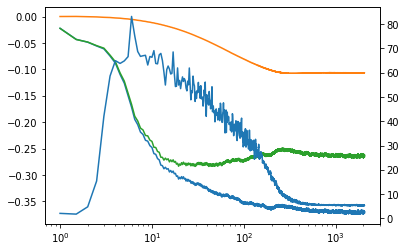

In [4]:
x=np.linspace(1,2051,4100)
plt.plot(x,ds['EXP00_rest6m2000'].zgDE)
plt.plot(x,ds['EXP00_rest6m2000'].zgDE_gm)

plt.plot(x,ds['EXP00_rest6m2000'].zgDE-ds['EXP00_rest6m2000'].zgDE_gm)
ax2 = plt.twinx()
ax2.plot(x,ds['EXP00_rest6m2000'].psi_dmoc)
plt.xscale('log')

In [4]:
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy import stats

dt=ds['EXP00_rest6m2000'].t.diff('t')[0]/86400/360
t_years=np.arange(1,(len(ds['EXP00_rest6m2000'].t)+2)*dt,dt)

Text(0.5, 1.0, 'Spin-up adjustment')

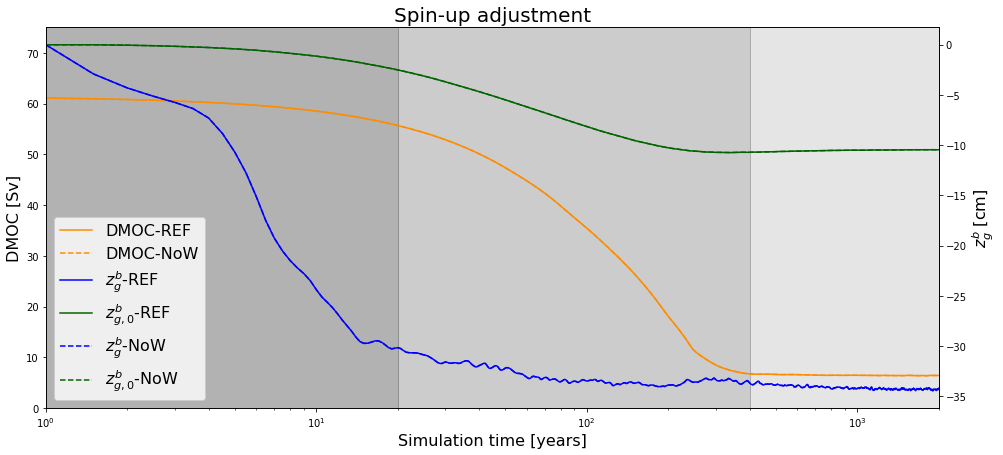

In [7]:
fig,ax = plt.subplots(figsize=(16,7))
exp = 'EXP00_rest6m2000'
exp1 = 'EXP01_rest6m2000'

zg =   {exp: ds[exp].zgDE.rolling({'t':2}).mean('t') for exp in ds}
zg0 =   {exp: ds[exp].zgDE_gm.rolling({'t':2}).mean('t') for exp in ds}
for exp in ds: zg[exp][0]=0; zg0[exp][0]=0
dmoc = {exp: np.transpose(lowess(ds[exp].psi_dmoc.values, ds[exp].t,frac=0.05))[1] for exp in ds}
#ax.plot(t_years,ds[exp].psi_dmoc,c='dimgrey',label='DMOC-REF')
#ax.plot(t_years,ds[exp].psi_dmoc,c='dimgrey',linestyle='--',label='DMOC-NoW')
ax.plot(t_years,dmoc[exp],c='Darkorange',label='DMOC-REF')
ax.plot(t_years,dmoc[exp1],c='Darkorange',linestyle='--',label='DMOC-NoW')

#ax.fill_between(range(len(s)), 0, max(zg[sim[0]]), where=(s < 1.25) & (s > 0.75), alpha=0.5)
ax.fill_between([0,20], 75,alpha=0.6,color='grey')
ax.fill_between([20,400], 75,alpha=0.4,color='grey')
ax.fill_between([400,3000], 75,alpha=0.2,color='grey')

ax0=ax.twinx()
z=ax0.plot(t_years,zg[exp]*100,c='b',label='$z_g^b$-REF')
z=ax0.plot(t_years,zg0[exp]*100,c='Darkgreen',label='$z_{g,0}^b$-REF')
z=ax0.plot(t_years,zg[exp1]*100,c='b',linestyle='--',label='$z_g^b$-NoW')
z=ax0.plot(t_years,zg0[exp1]*100,c='Darkgreen',linestyle='--',label='$z_{g,0}^b$-NoW')

ax.set_xscale('log')
ax.set_xlim(1,2e3)
ax.set_ylim(0,75)
ax.set_ylabel('DMOC [Sv]',fontsize=16)
ax0.set_ylabel('$z_g^b$ [cm]',fontsize=16)
ax.set_xlabel('Simulation time [years]',fontsize=16)
plt.legend(ax.get_legend_handles_labels()[0]+ax0.get_legend_handles_labels()[0],
          ax.get_legend_handles_labels()[1]+ax0.get_legend_handles_labels()[1],fontsize=16)
ax.set_title('Spin-up adjustment',fontsize=20)
#plt.savefig('Figures/Fig3_0to2000_v2.png', dpi=150, transparent=True, bbox_inches='tight')

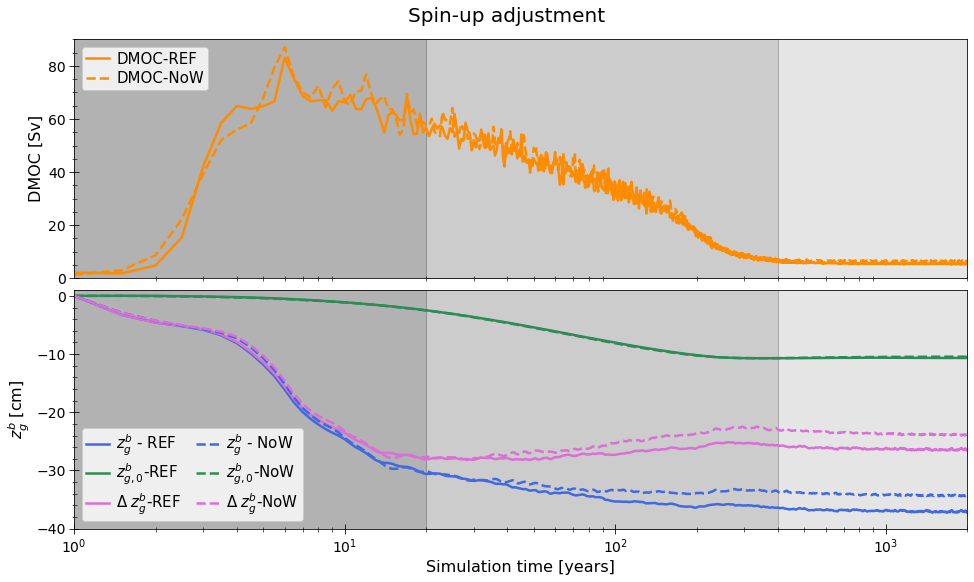

In [38]:
fig,ax = plt.subplots(2,figsize=(16,9))
exp0 = 'EXP00_rest6m2000'
exp1 = 'EXP01_rest6m2000'

zg =   {exp: ds[exp].zgDE.rolling({'t':2}).mean('t') for exp in ds}
zg0 =   {exp: ds[exp].zgDE_gm.rolling({'t':2}).mean('t') for exp in ds}
for exp in ds: zg[exp][0]=0; zg0[exp][0]=0
dmoc = {exp: np.transpose(lowess(ds[exp].psi_dmoc.values, ds[exp].t,frac=0.001))[1] for exp in ds}


#ax.plot(t_years,ds[exp].psi_dmoc,c='dimgrey',label='DMOC-REF')
#ax.plot(t_years,ds[exp].psi_dmoc,c='dimgrey',linestyle='--',label='DMOC-NoW')
ax[0].plot(t_years,dmoc[exp0],c='Darkorange',label='DMOC-REF')
ax[0].plot(t_years,dmoc[exp1],c='Darkorange',linestyle='--',label='DMOC-NoW')
ax[0].legend(fontsize=15,loc='upper left',borderpad=0.3,handlelength=1.5,handletextpad=0.5,labelspacing=0.3)

ax[0].fill_between([0,20], 90,alpha=0.6,color='grey')
ax[0].fill_between([20,400], 90,alpha=0.4,color='grey')
ax[0].fill_between([400,3000], 90,alpha=0.2,color='grey')


ax[1].plot(t_years,zg[exp0]*100,c='royalblue',label='$z_g^b$ - REF')
ax[1].plot(t_years,zg0[exp0]*100,c='seagreen',label='$z_{g,0}^b$-REF')
ax[1].plot(t_years,(zg[exp0]-zg0[exp0])*100,c='orchid',label='$\Delta\; z_{g}^b$-REF')

ax[1].plot(t_years,zg[exp1]*100,c='royalblue',linestyle='--',label='$z_g^b$ - NoW')
ax[1].plot(t_years,zg0[exp1]*100,c='seagreen',linestyle='--',label='$z_{g,0}^b$-NoW')
ax[1].plot(t_years,(zg[exp1]-zg0[exp1])*100,c='orchid',linestyle='--',label='$\Delta\; z_{g}^b$-NoW')

ax[1].legend(fontsize=15,loc='lower left',borderpad=0.3,handlelength=1.5,handletextpad=0.5,labelspacing=0.3,ncol=2,columnspacing=1)

ax[1].fill_between([0,20], -40,1,alpha=0.6,color='grey')
ax[1].fill_between([20,400], -40,1,alpha=0.4,color='grey')
ax[1].fill_between([400,3000], -40,1,alpha=0.2,color='grey')


for i in range(2):
    ax[i].set_xscale('log')
    ax[i].set_xlim(1,2e3)
ax[0].set_ylim(0,90)
ax[0].set_ylabel('DMOC [Sv]',fontsize=16)
ax[0].set_xticks([])
ax[1].set_ylim(-40,1)
ax[1].set_ylabel('$z_g^b$ [cm]',fontsize=16)
ax[1].set_xlabel('Simulation time [years]',fontsize=16)
ax[1].set_yticks(ax[1].get_yticks()[:-1])
plt.subplots_adjust(hspace=0.05)
fig.suptitle('Spin-up adjustment',fontsize=20,y=0.93)
plt.savefig('figures/Fig4_spinup_final.png', dpi=150, transparent=True, bbox_inches='tight')